In [1]:
import numpy as np
import math 
import os
import matplotlib.pyplot as plt
import pickle

In [2]:
# Defines a Node of The Tree
class Node():
    def __init__(self, label):
        self.label = label # label of the atribute
        self.branches = dict() # receives a value of atribute and returns to which branch it should go
        self.counter = -1

## Functions Used to load data from the CSV File

- The Split data function is used to split the csv file into a part used for training the decision tree and a part used for testing
- train-p being a number in the interval ]0,1] representing percentage of the file to be used for training
- The split is performed on a shuffled dataset therefore diferent runs, even with same train_p, will produce diferrent training datasets resulting in diferent decision trees.

In [3]:
def load_data(path, add_id=False):
    data = np.genfromtxt(path, delimiter=',', dtype=str)
    
    if add_id:
        ids= np.array([["ID"] for _ in range(len(data))])
        data = np.hstack((ids, data))
    return data


    
def save_data(data, path):
    np.savetxt(path, data, delimiter=',', fmt='%s')

def save_tree(tree, filename):
    with open(filename, 'wb') as file:
        pickle.dump(tree, file)
    
def split_data(train_p, data=None, path=None, save_path=None, name=None):

    if (data == None):
        data = load_data(path)
    id_row = data[0]
    id_collumn = data[:,0]
    
    data_copy = np.copy(data)
    np.random.shuffle(data_copy[1:])
    data_len = np.shape(data)[0]-1
    num_spliter = int(math.floor(data_len*train_p))
    
    train_data = np.vstack([id_row,data_copy[1:num_spliter+1]])
    test_data = np.vstack([id_row,data_copy[num_spliter+1:]])
    
    if save_path and name:
        os.makedirs(save_path, exist_ok=True) 
        save_data(train_data, save_path+"/" + name + '_train.csv')
        save_data(test_data, save_path + "/"+name + '_test.csv')

        
    return train_data, test_data

# Discretizing Values

 - The first function checks which attributes haves values which have to be discretized, which atributes have numeric values.
 - The second function discretizes values of the collums passed to it while creating the intervals.
 - The third function discretizes values with preset intervals, used for data to be classified by the decision tree

In [4]:
def check_notDisc(data):
    '''Returns all collumns with values that should be discretized'''
    len_data = data.shape[0]
    num_col = data.shape[1]
    nonDisc_col = []
    for i in range(1,num_col):
        col_values = data[1:, i]
        try:
            col_numeric = col_values.astype(np.float64)  # Attempt to convert column values to float64
            #print(col_numeric)
            nonDisc_col.append(i)
        except ValueError: 
            continue
    return nonDisc_col


def discretize_nbins(data, columns, nbins):
    '''Discretizes with a predefined number of intervals'''
    discretized_data = data.copy()
    inter = []

    for col in columns:
        col_values = data[1:, col].astype(np.float64)
        min_val = np.min(col_values)
        max_val = np.max(col_values)
        interval_size = (max_val - min_val) / nbins
        intervals = [np.round(min_val + i * interval_size, 2) for i in range(nbins + 1)]
        split_points = intervals[1:-1]
        inter.append(intervals)

        discretized_col = np.empty_like(col_values, dtype=object)
        
        for i in range(len(split_points)+1):
            if i == 0:
                discretized_col[col_values <= split_points[i]] = f"<={split_points[i]}"
            elif i == len(split_points):
                discretized_col[col_values > split_points[i-1]] = f">{split_points[i-1]}"
            else:
                discretized_col[(col_values > split_points[i - 1]) & (col_values <= split_points[i])] = \
                    f"{split_points[i - 1]} - {split_points[i]}"
                    
        discretized_data[1:, col] = discretized_col

    return discretized_data, inter

def discretize_nbins_intervals(data, columns, intervals_list):
    discretized_data = data.copy()

    for col, intervals in zip(columns, intervals_list):
        col_values = data[1:, col].astype(np.float64)
        split_points = intervals[1:-1]

        discretized_col = np.empty_like(col_values, dtype=object)
        
        for i in range(len(split_points)+1):
            if i == 0:
                discretized_col[col_values <= split_points[i]] = f"<={split_points[i]}"
            elif i == len(split_points):
                discretized_col[col_values > split_points[i-1]] = f">{split_points[i-1]}"
            else:
                discretized_col[(col_values > split_points[i - 1]) & (col_values <= split_points[i])] = \
                    f"{split_points[i - 1]} - {split_points[i]}"
                    
        discretized_data[1:, col] = discretized_col

    return discretized_data

# Functions to Print a Decision Tree

In [5]:
def print_tree(root):
    print_branch(root, '')

def print_branch(node, spaces):
    print(spaces + '<' + str(node.label) + '>')
    spaces = spaces + '    '
    for branch in node.branches.items():
    # items() returns a list of the tuples in the dictionary
        if len(branch[1].branches) == 0:
            print(spaces + branch[0] + ':',
            branch[1].label, '(' + str(branch[1].counter) + ')')
        else:
            print(spaces + branch[0] + ':')
            print_branch(branch[1], spaces + '    ')

# Functions used for inducing a decision tree


In [6]:
 
def get_values(data, attributes):
    '''For each atribute, constructs a set containing all unique values in that atribute, returns a list of these sets'''
    values = []
    num_attributes = len(attributes)
    
    for col in range(num_attributes - 1): 
        unique_values = np.unique(data[:, col]) 
        values.append(set(unique_values))
    
    return values

def most_common(data):
    values, count = np.unique(data[:,-1], return_counts=True)
    most_common_index = np.argmax(count)
    return data[:,-1][most_common_index]

def is_pure(data):
    return len(np.unique(data[:,-1]))==1

def entropy(data):
    _, counts = np.unique(data[:, -1], return_counts=True)
    probabilities = counts / len(data)
    #probabilities = probabilities[probabilities != 0]
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

## Gini Metrics

In [7]:
def gini(data):
    _, counts = np.unique(data[:, -1], return_counts=True)
    probabilities = counts / len(data)
    gini_impurity = 1 - np.sum(probabilities ** 2)
    return gini_impurity

def calc_gini_impurity(attribute, data):
    attribute_values = np.unique(data[:, attribute])
    total_impurity = 0
    for value in attribute_values:
        subset = data[data[:, attribute] == value]
        subset_impurity = gini(subset)
        weight = len(subset) / len(data)
        total_impurity += weight * subset_impurity
    
    return total_impurity

## Entropy Calculation

In [8]:
def calc_entropy(attribute, data):
    attribute_values = np.unique(data[:, attribute])
    total_entropy = 0
    
    for value in attribute_values:
        subset = data[data[:, attribute] == value]
        subset_entropy = entropy(subset)
        weight = len(subset) / len(data)
        total_entropy += weight * subset_entropy
    
    return total_entropy

## Information Gain

In [9]:
def information_gain(attribute, data, parent_entropy):
    attribute_values = np.unique(data[:, attribute])
    total_entropy = 0
    
    for value in attribute_values:
        subset = data[data[:, attribute] == value]
        subset_entropy = entropy(subset)
        weight = len(subset) / len(data)
        total_entropy += weight * subset_entropy
    
    return parent_entropy - total_entropy

## Auxiliar functions for ID3

best atribute returns which is the best atribute according to the metric selected in the ``calc=``  argument, entro being entropy calculation, ig being information gain and gini being gini. 

In [10]:
def best_attribute(data, calc="entro"):
    #print("Dddd, ", data)
    parent_entropy = entropy(data)
    data_len = np.shape(data)[0]
    num_col = np.shape(data)[1] 
    #print("bebebe ", data_len, num_col)
    
    if data_len ==0:
        return None

    if calc =="entro":
        entropies = []
        for at in range(num_col-1):
            entropies.append(calc_entropy(at, data))
            
        #print(entropies, np.argmin(entropies))
        return np.argmin(entropies)
    
    elif calc=="ig":
            gains = []
            for at in range(num_col-1):
                gains.append(information_gain(at, data, parent_entropy))
                
            return np.argmax(gains)
    
    elif calc == "gini":
        gini_ind = []
        for at in range(num_col-1):
            gini_ind.append(calc_gini_impurity(at, data))
        return np.argmin(gini_ind)

def subset(data, attribute, val):
    ind = np.where(data[:, attribute] == val)[0]
    return np.delete(np.copy(data[ind]), attribute, axis=1)

## Iterative Dichotomoizer 3 algorithm

  - the ``calc=`` argument defines which metric to use. 

In [11]:
def id3(data, attributes, values, calc="entro"):
    #data = np.copy(data)
    #attributes = np.copy(attributes)
    #values = np.copy(values)
    
    #print(np.shape(data))
    if is_pure(data):
        node = Node(data[0][-1])
        node.counter = np.shape(data)[0]
    
    elif np.shape(data)[1] ==1:
        node = Node(most_common(data))
        node.counter = np.shape(data)[0]
        
    
    else:
        #print(attributes)
        ind_best_at = best_attribute(data, calc=calc)
        #print(attributes[ind_best_at])

        node = Node(attributes[ind_best_at])

        
        for value in values[ind_best_at]:
            node.branches[value] = None
            
        #print(attributes)
        attributes_copy = np.delete(attributes, ind_best_at)
        #print(attributes_copy)
        values_copy = np.delete(values, ind_best_at)
        

        #print(values_copy, attributes_copy)
        #print("-------------------")
        for value in node.branches:

            data_v = np.copy(subset(data, ind_best_at, value))
            #print(data_v)
            if np.shape(data_v)[0]>0:
                
                node.branches[value] = id3(data_v, attributes_copy, values_copy)
                
            else:
                leaf = Node(most_common(data))
                leaf.counter=0
                node.branches[value]= leaf

    return node

# Creation of a binary tree

In [12]:
def create_tree(csv_file_path, number_of_intervals, metric="entro"):
    '''Creates decision tree for the csv provided, returns a tuple with (decision_tree, list_of_intervals, discretized_data)'''
    values = load_data(csv_file_path) #loads dataset from csv file
    return create_tree_from_np_array(values, number_of_intervals, metric=metric)
    
    
def create_tree_from_np_array(array, number_of_intervals, metric="entro", test_for_discretization=True):
    if (test_for_discretization):
        discretized, intervals = discretize_nbins(array, check_notDisc(array), number_of_intervals) # discretizes dataset
        res_val = get_values(discretized[1:,1:], discretized[0,:]) 
        return id3(discretized[1:,1:], discretized[0,1:], res_val, metric), intervals, discretized
    else:
        res_val = get_values(array[1:,1:], array[0,:]) 
        return id3(array[1:,1:], array[0,1:], res_val, metric), None, array

# Functions to Predict a sample given a data tree

In [13]:

def predict_sample(decision_tree_root, atributes_or_data, sample):
    '''Sample must be discretized, the function receives either a list of atributes or the dataset obtained from load data
    and gets the atributes from there '''
    if not isinstance(atributes_or_data, list):
        atributes = atributes_or_data[0,1:].tolist()
    else:
        atributes = atributes_or_data
    sample_dict = dict()
    for atribute, value in zip(atributes, sample):
        sample_dict[atribute] = value
    return predict_sample_recursive(decision_tree_root, sample_dict)
    

def predict_sample_recursive(decision_tree_node, sample_dict):
    if len(decision_tree_node.branches) == 0: return decision_tree_node.label
    sample_interval = sample_dict[decision_tree_node.label]
    branch = decision_tree_node.branches[sample_interval]
    return predict_sample_recursive(branch, sample_dict)

## Test of Creation of a data Tree then prediction of it's first hundred samples

In [14]:
tree,intervals, data = create_tree("./datasets/iris.csv", 3)
print_tree(tree)
for i in range(1,100):
    print(data[i,1:])
    print(predict_sample(tree, data, data[i,1:-1])) # The -1 is necessary to not include the class of the sample


<petalwidth>
    0.9 - 1.7:
        <petallength>
            2.97 - 4.93:
                <sepallength>
                    5.5 - 6.7: Iris-versicolor (33)
                    <=5.5:
                        <sepalwidth>
                            <=2.8: Iris-versicolor (11)
                            >3.6: Iris-versicolor (0)
                            2.8 - 3.6: Iris-versicolor (1)
                    >6.7: Iris-versicolor (3)
            >4.93:
                <sepallength>
                    5.5 - 6.7:
                        <sepalwidth>
                            <=2.8: Iris-virginica (4)
                            >3.6: Iris-versicolor (0)
                            2.8 - 3.6: Iris-versicolor (1)
                    <=5.5: Iris-versicolor (0)
                    >6.7: Iris-virginica (1)
            <=2.97: Iris-versicolor (0)
    <=0.9: Iris-setosa (50)
    >1.7:
        <petallength>
            2.97 - 4.93:
                <sepalwidth>
                    <=2.8: Iris-vi

# Prediction of a list of Samples

In [15]:
def predict_dataset(decision_tree, test_dataset):
    '''Tests an array of samples'''
    atributes = test_dataset[0,1:].tolist()
    data = test_dataset[1:,1:] # removes labels (first line) and id (first collumn)
    results = []
    for i in range(np.shape(data)[0]): # loop by number of collumns
        results.append(predict_sample(decision_tree, atributes, data[i]))
    return np.array(results)

In [16]:
def train_and_test(csvpath, train_p, number_of_intervals, metric="entro", test_for_discretization = True):
    '''Creates a decision tree with (train_p) * 100 % of the samples in the csv and the rest uses to test
    the tree, returns a tuple (predicitions,accuracy) '''
    train_data, test_data = split_data(train_p, path=csvpath)
    tree, intervals, _ = create_tree_from_np_array(train_data, number_of_intervals, metric=metric, test_for_discretization=test_for_discretization)
    if (test_for_discretization):
        discretized = discretize_nbins_intervals(test_data, check_notDisc(test_data), intervals)
        prediction = predict_dataset(tree, discretized)
    else:
        prediction = predict_dataset(tree, test_data)
    samplesize = len(prediction)
    accuracy = np.count_nonzero(prediction==test_data[1:,-1]) / samplesize
    return prediction, accuracy

def arvore_plus_teste(path, train_p, add_id=False, to_print=True, nbins=3, calc="entro"):
    data = load_data(path, add_id=add_id)
    treino, teste = split_data(train_p=train_p, data=data)
    to_disc=check_notDisc(treino)
    if len(to_disc)>0:
        treino, inter = discretize_nbins(treino,to_disc, nbins=nbins)
        teste = discretize_nbins_intervals(teste, to_disc, inter)
    arvore = id3(treino[1:,1:], treino[0,1:], get_values(treino[1:,1:], treino[0,:]), calc=calc)
    
    if to_print:
        print("ARVORE:")
        print_tree(arvore)
        print("FIM DA ARVORE")
        
    resultados_teste = predict_dataset(arvore, teste)
    #print(resultados_teste[1])
    return resultados_teste, (treino, teste)


In [17]:
p,a = train_and_test("./datasets/restaurant.csv", 0.1, 3, test_for_discretization=False)
print(p)
print(a)

['Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes']
0.45454545454545453


# Function to plot graphs on accuracy of decision trees

In [18]:

def plot_accuracy(csvpath, num_runs, num_intervals=3, test_for_discretization = True, metric="entro", val_p = np.arange(0.2,1.00, 0.05)):
    res_ac = []
    res_std = []
    len_res = []
    for p in val_p:
        res_p_sp = []
        for a in range(num_runs):
            try:
                aux = train_and_test(csvpath, p, num_intervals, test_for_discretization=test_for_discretization, metric=metric)[1]
                res_p_sp.append(aux)
            except KeyError:
                res_p_sp.append(np.nan)
        res_ac.append(np.nanmean(res_p_sp))
        res_std.append(np.nanstd(res_p_sp))
        len_res.append((len(res_p_sp),np.sum(np.isnan(res_p_sp))))

    plt.plot(val_p, res_ac, '-o')

    plt.xlabel("Percentagem dos Dados usado para treino")
    plt.ylabel("Accuracy")
    plt.show()

    plt.xlabel("Percentagem dos Dados usado para treino")
    plt.ylabel("STD Accuracy")
    plt.plot(val_p, res_std, '-o')

# Accuracy of Restaurants Dataset

## With Entropy Calculation

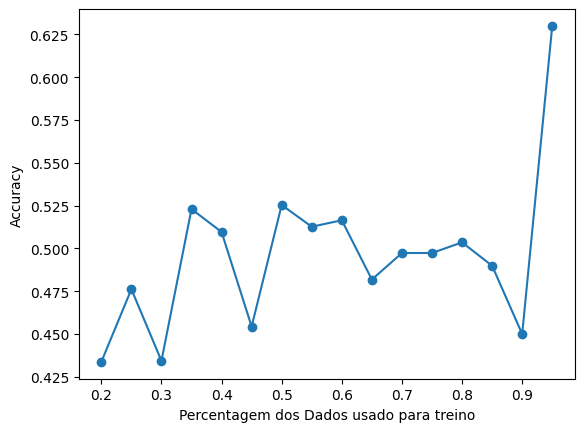

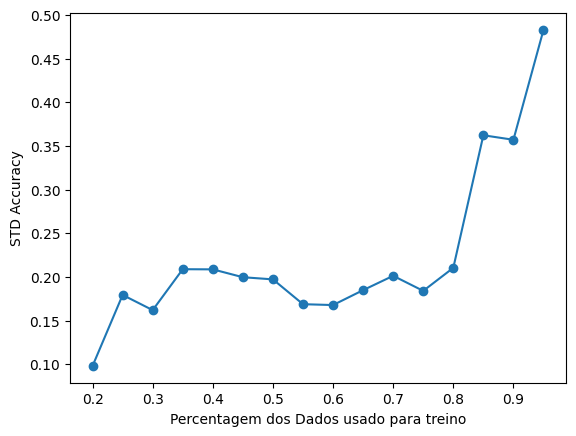

In [19]:
plot_accuracy("./datasets/restaurant.csv", 100)


## With Information Gain

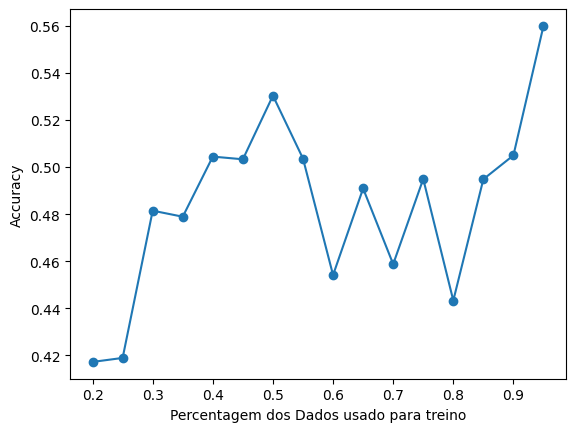

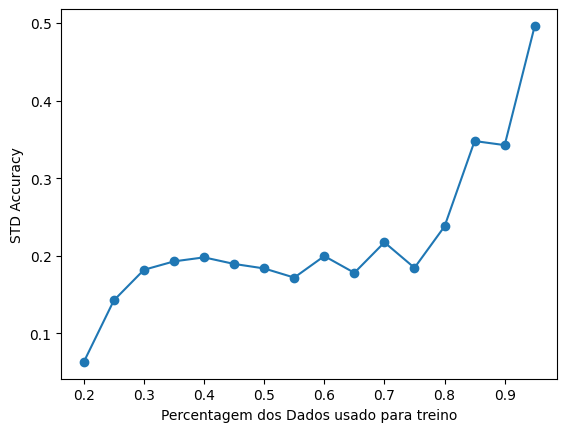

In [20]:
plot_accuracy("./datasets/restaurant.csv", 100, metric="ig")


## With Gini

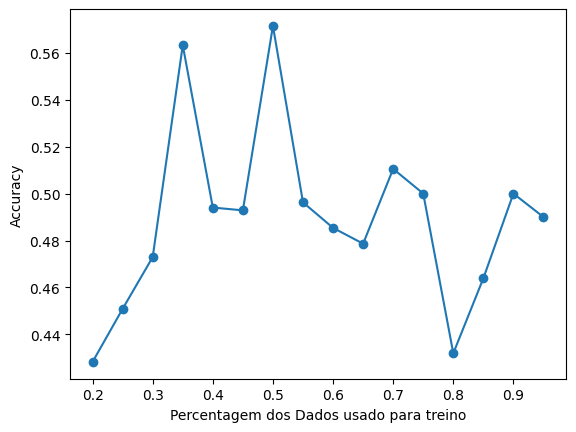

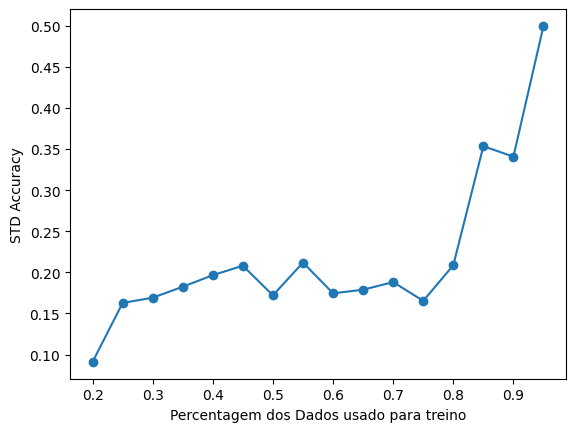

In [21]:
plot_accuracy("./datasets/restaurant.csv", 100, metric="gini")

# Accuracy of Weather Decision Tree


## With Entropy Calculation

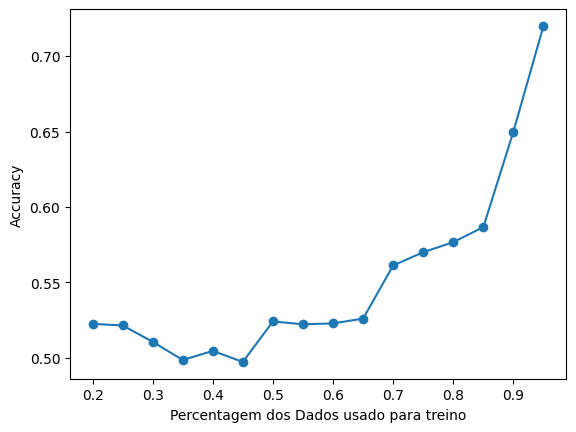

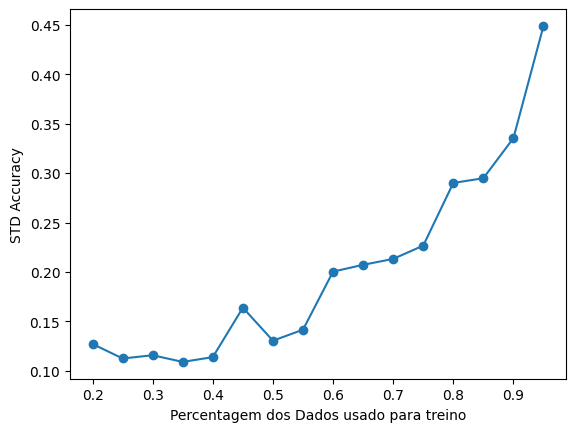

In [22]:
plot_accuracy("./datasets/weather.csv", 100)

## With Information Gain

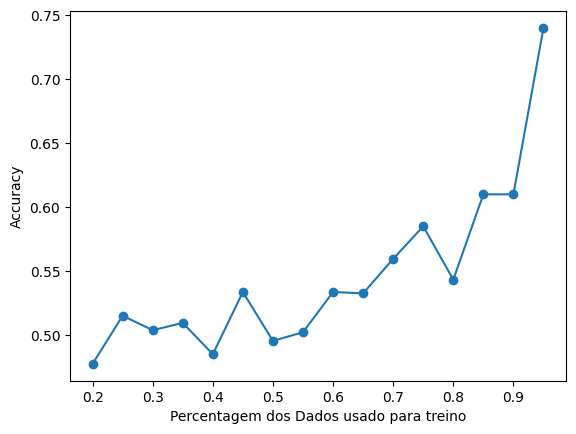

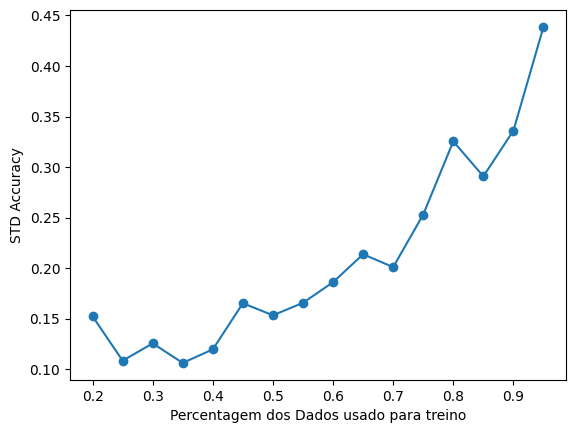

In [23]:
plot_accuracy("./datasets/weather.csv", 100, metric="ig")

## With Gini

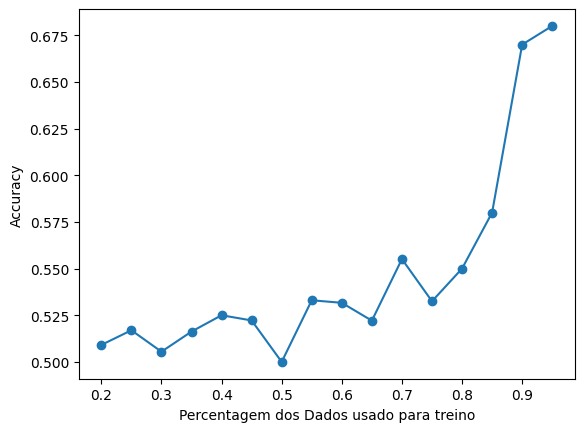

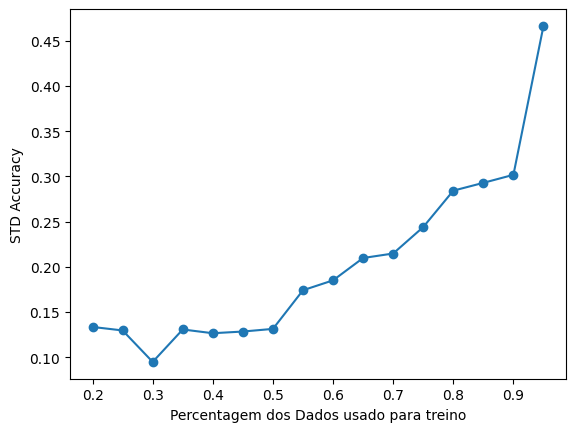

In [24]:
plot_accuracy("./datasets/weather.csv", 100, metric="gini")

# Accuracy of iris decision Tree

## With Entropy Calculation

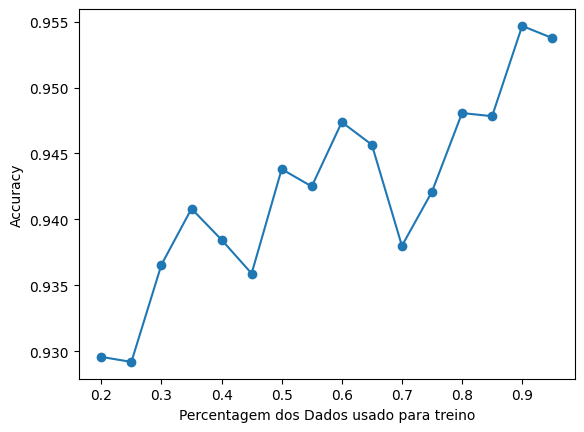

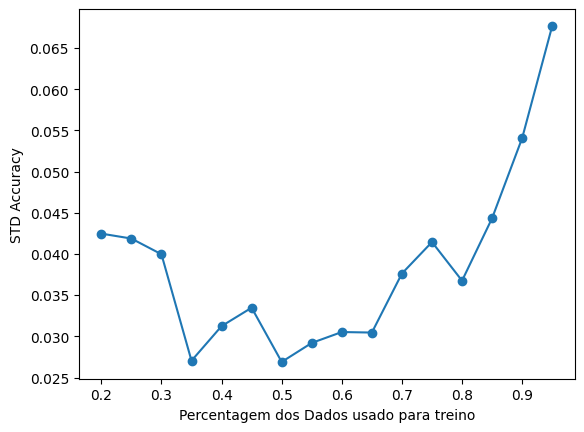

In [25]:
plot_accuracy("./datasets/iris.csv", 100)

## With Information Gain

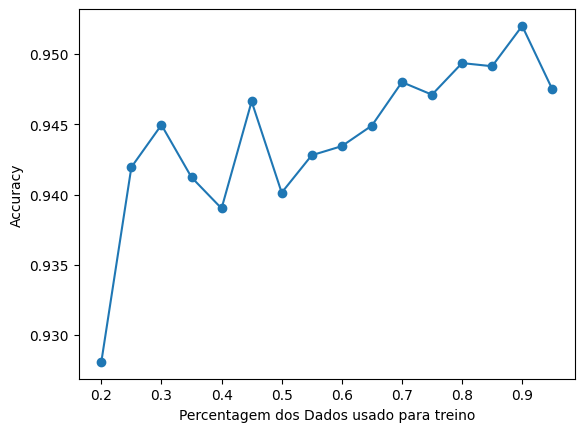

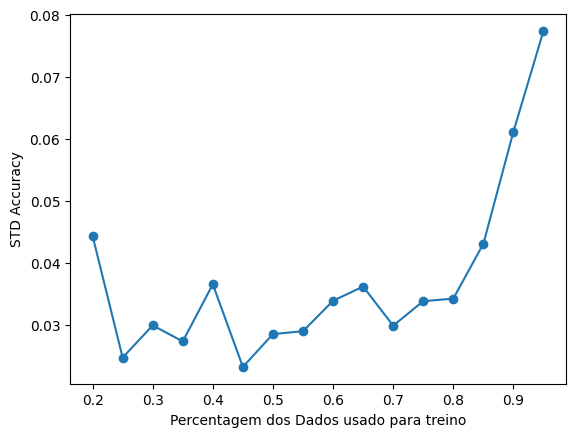

In [26]:
plot_accuracy("./datasets/iris.csv", 100, metric="gini")

## With Gini

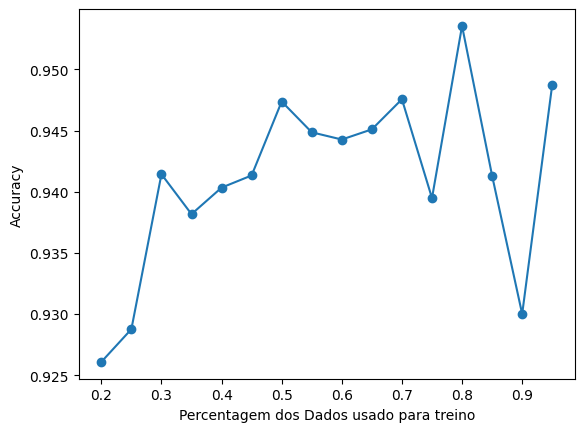

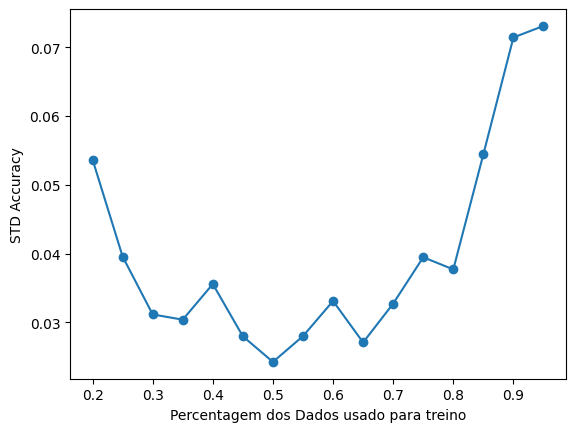

In [27]:
plot_accuracy("./datasets/iris.csv", 100, metric="ig")

# Accuracy of Connect4 decision Tree

# With Entropy Calculation

In [28]:
#plot_accuracy("./datasets/connect4.csv",3, test_for_discretization=False)

## With Information Gain

In [29]:
#plot_accuracy("./datasets/connect4.csv",3, test_for_discretization=False, metric="ig")

## With Gini

In [30]:
#plot_accuracy("./datasets/connect4.csv",3, test_for_discretization=False, metric="gini")

# Using Connect 4 decision tree as player AI

In [31]:
## Creating a Decision Tree

tree = create_tree("datasets/connect4.csv", 3, metric="ig")[0]
save_tree(tree, "./connect4.pickle")

In [32]:
# Definição de algumas constantes usadas durante o código
NUM_ROW = 6
NUM_COL = 7
EMPTY = "-"
PLAYER_PIECE = "X"
AI_PIECE = "O"


In [33]:
#arquivo ai_dt.py

import copy
import random
from sys import exit

def load_tree(filename):
    with open(filename, 'rb') as file:
        tree = pickle.load(file)
    return tree

dataset = load_data("datasets/connect4.csv", add_id=True)
arvore = load_tree("./connect4.pickle")
class ai_dt:
    def __init__(self):
        pass
    
    def get_format(self, state):
        features = []
        num_rows = len(state.board)
        num_cols = len(state.board[0])
        for col in range(num_cols):
            for row in range(num_rows):
                cell = state.board[row][col]
                if cell == PLAYER_PIECE:
                    features.append("x")
                elif cell == AI_PIECE:
                    features.append("o")
                else:
                    features.append("b")
        return features
    
    def get_move(self, state):
        pl = state.player()
        acw = []
        acd = []
        
        for action in state.availableCollumns():
            new_state = copy.deepcopy(state)
            new_state.putGamePiece(action, "O")
            if new_state.game_winner == "O":
                return None, action
            
        for action in state.availableCollumns():
            new_state = copy.deepcopy(state)
            new_state.putGamePiece(action, "X")
            if new_state.game_winner == "X":
                return None, action
            
        for action in state.availableCollumns():
            new_state = copy.deepcopy(state)
            new_state.putGamePiece(action, "O")
            ns_dt = np.array(self.get_format(new_state))  # Convertendo para matriz numpy bidimensional
            predicao = predict_sample(arvore, dataset, ns_dt)
            #print(predicao)
            if predicao==["loss"]:
                acw.append(action)
            if predicao==["draw"]:
                acd.append(action)
        if len(acw)==0:
            acw = acd
        if len(acw) == 0:
            
            acw = state.availableCollumns()
        return None,random.choice(acw)

## Importando a classe game e suas dependências, implementadas no trabalho anterior do jogo Connect 4.

O código abaixo gera dois dicionarios usados no calcúlo das heuristicas de segmentos da board, ambos tem como chave uma posição da board, já os valores são:
- index_dict: Os indices dos segmentos na lista de heuristica, que terão suas heuristicas alteradas ao colocar uma peça nessa posição.
- pos_dict: Uma lista das listas de posições contidas no segmentos que contem a posição chave
abaixo tem um exemplo de ambos dicionarios

In [34]:
def get_segments(board):
        segments = []
        # Verifica linhas e colunas
        for i in range(NUM_ROW):
            line = board[i]
            for j in range(4):
                segments.append(line[j : j + 4])
            col = board[:, i]
            for j in range(3):
                segments.append(col[j : j + 4])

        # Verifica a ultima coluna
        col = board[:, NUM_COL - 1]
        for j in range(3):
            segments.append(col[j : j + 4])

        # Verifica as diagonais principais
        for i in range(-2, 4):
            dia = np.diag(board, i)
            for j in range(len(dia) - 3):
                segments.append(dia[j : j + 4])

        # Dá flip no array e verifica as diagonais principais do array flipado
        # (equivalentes às diagonais perpendiculares às principais do array original)
        state_tr = np.fliplr(board)
        for i in range(-2, 4):
            dia = np.diag(state_tr, i)
            for j in range(len(dia) - 3):
                segments.append(dia[j : j + 4])
        return segments

def gen_dict():
    board = [[f"{i},{j}" for j in range(7)]for i in range(6)]
    board = np.array(board)
    segments = get_segments(board)
    index_dict = {}
    position_dict = {}
    for j in range(7):
        for i in range(6):
            temp = []
            for z,segment in enumerate(segments):
                if f"{i},{j}" in segment:
                    temp.append(z)
                index_dict[(i,j)] = temp
                position_dict[(i,j)] = [[tuple(map(int, pos.split(","))) for pos in segments[index]] for index in temp]
    return index_dict,position_dict
index_dict, pos_dict = gen_dict()

A seguir temos a definição da classe game, que representa um jogo, nela se tem os atributos:
- game_winner: armazena quem ganhou o jogo ou a peça vazia, caso ninguem tenha ganhado
- board_is_full: boolean que fica verdadeiro quando todas as colunas estão cheias
- segment_heuristics: lista da heuristica de cada segmento
- self.board: array que representa o tabuleiro
- self.last_move: guarda quem jogou por ultimo


In [35]:
class game:
    def __init__(self, calculate_heuristics=True):
        self.game_winner = EMPTY  # variáveis que controlam o fim do jogo
        self.board_is_full = False
        if calculate_heuristics: self.segment_heuristics = [0 for _ in range (69)] # Caso bool seja falso, não é necessario inicializar essa variavel
        self.board = np.full([NUM_ROW, NUM_COL], EMPTY)
        self.last_move = None
        self.calculate_heuristics = calculate_heuristics 
        self.first = PLAYER_PIECE #or AI_PIECE
        self.turn = 0

    def drawBoard(self):
        for i in range(7): print(i, end=" ") #imprime os numeros das colunas
        print() # coloca newline
        for line in np.flip(self.board, 0):
            for piece in line:
                print(piece, end=" ")
            print()# coloca newline
        return

    """Dado um input, verifica a função availableCollumns para saber se é válido.
    Se não for pede novamente o input, do contrário usa a função putGamePiece para alterar a board."""

    def playOneTurn(self):
        available = self.availableCollumns()
        try:  # error handling
            collumn = int(
                input("Choose in which collumn do you wanna play or press 9 to quit: ")
            )
        except:
            collumn = -1

        while collumn not in available:
            if collumn == 9:
                exit()  # opção para quitar
            try:  # more error handlings
                collumn = int(
                    input(
                        "The collumn you selected is either full or invalid, choose another one or press 9 to quit: "
                    )
                )
            except:
                collumn = -1
        self.putGamePiece(collumn, PLAYER_PIECE)
        return

    """Verifica qual a próxima row vazia e põe a peça nesta row. 
    Checa após cada movimento a função check_win_after_move para saber se houve ganhador.
    caso calculate_heuristics==True calcula as heuristicas dos segmentos alterados por aquele movimento
    """

    def putGamePiece(self, collumn, piece):
        available = self.availableCollumns()
        if collumn not in available:
            print("The last move was invalid, below is the last state of the board and the move made, the game will quit")
            self.drawBoard()
            print("last move = {collumn}")
            exit()

        piece_placement = self.nextEmptyRowinCollumn(collumn)
        self.board[piece_placement][collumn] = piece
        if self.check_win_after_move(piece_placement, collumn, piece):
            self.game_winner = piece  # checar se houve ganhador
        elif not self.availableCollumns():
            self.board_is_full = True  # se não há colunas vazias, a board está cheia
        # not list aparentemente é um dos jeitos mais eficientes de checar se uma lista está vazia, python é estranho - M
        if self.calculate_heuristics: self.update_heuristics(piece_placement, collumn) # atualiza as heuristicas se o bool for True
        self.last_move = collumn
        self.turn += 1
        return

    """Checa a última row para saber quais colunas não estão cheias. Retorna a lista de colunas."""

    def availableCollumns(self):
        available = []
        for i, value in enumerate(self.board[NUM_ROW - 1]):
            if value == EMPTY:
                available.append(i)
        return available

    """Dado uma coluna, verifica qual a próxima row vazia. Retorna o número da row."""

    def nextEmptyRowinCollumn(self, collumn):
        for i, value in enumerate(self.board[:, collumn]):
            if value == EMPTY:
                return i
        return

    """Função que checa se houve vitória após cada movimento. 
    Verifica somente os arrays que contém a peça em [move_row, move_col]."""
    
    def check_win_after_move(self, move_row, move_col, piece):
        win_segment = [piece, piece, piece, piece]
        for i in self.segments_that_intersect(move_row, move_col): # verifica se houve vitoria em todos os segmentos que são modificados pelo ultimo movimento
            if i == win_segment: return True
        return False

    # retorna lista com todos os segmentos de 4 em todas as direções
                
    def get_segments(self):
        segments = []
        # Verifica linhas e colunas
        for i in range(NUM_ROW):
            line = self.board[i]
            for j in range(4):
                segments.append(line[j : j + 4])
            col = self.board[:, i]
            for j in range(3):
                segments.append(col[j : j + 4])

        # Verifica a ultima coluna
        col = self.board[:, NUM_COL - 1]
        for j in range(3):
            segments.append(col[j : j + 4])

        # Verifica as diagonais principais
        for i in range(-2, 4):
            dia = np.diag(self.board, i)
            for j in range(len(dia) - 3):
                segments.append(dia[j : j + 4])

        # Dá flip no array e verifica as diagonais principais do array flipado
        # (equivalentes às diagonais perpendiculares às principais do array original)
        state_tr = np.fliplr(self.board)
        for i in range(-2, 4):
            dia = np.diag(state_tr, i)
            for j in range(len(dia) - 3):
                segments.append(dia[j : j + 4])
        return segments
    def segments_that_intersect(self, move_row, move_col):
        segments = [[self.board[pos[0],pos[1]] for pos in list] for list in pos_dict[(move_row,move_col)]]
        return segments

    # avalia um segmento e retorna a sua pontuação
    def update_heuristics(self,move_row,move_col):
        indexes = index_dict[(move_row,move_col)]
        segments = self.segments_that_intersect(move_row, move_col)             
        for i in range(len(indexes)):
            self.segment_heuristics[indexes[i]] = self.evaluate(segments[i])

    def evaluate(self, segment):
        count_x = 0
        count_o = 0

        for i in segment:
            if i == PLAYER_PIECE:
                count_x += 1
            elif i == AI_PIECE:
                count_o += 1

        if (count_x == 0 and count_o == 0) or (count_x > 0 and count_o > 0):
            return 0

        match count_x:
            case 1:
                return 1
            case 2:
                return 10
            case 3:
                return 50
            case 4:
                return 512

        match count_o:
            case 1:
                return -1
            case 2:
                return -10
            case 3:
                return -50
            case 4:
                return -512

    # avalia todos as posições para descobrir se há vencedor
    def evaluate_all(self):
        if self.game_winner == PLAYER_PIECE:
            return 512
        elif self.game_winner == AI_PIECE:
            return -512
        elif self.board_is_full:
            return 0
        else:
            sum = 0
            if self.player() == PLAYER_PIECE:
                sum = sum + 16
            elif self.player() == AI_PIECE:
                sum = sum - 16
            for segment in self.get_segments():
                sum = sum + self.evaluate(segment)
            return sum

    """Verifica se um determinado estado é um estado terminal/final 
    (estado em que um dos jogadores ganhou ou em que não há ações possíveis)"""

    def terminal(self):
        if self.game_winner == PLAYER_PIECE or self.game_winner == AI_PIECE:
            return True
        else:
            return self.board_is_full

    """Recebe um estado e retorna o vencedor (no caso deste existir)"""

    def checkwin_wholeboard(self):
        for (
            segment
        ) in self.get_segments():  # Itera sobre todos os segmentos de tamanho 4
            if np.array_equal(segment, ["X", "X", "X", "X"]):
                return "X"
            elif np.array_equal(segment, ["O", "O", "O", "O"]):
                return "O"
        return None

    #Função que retorna qual é o proximo jogador.

    def player(self):
        if self.board_is_full:
            return None
        
        elif self.first == AI_PIECE:
            if self.turn % 2 == 0:
                return AI_PIECE
            else:
                return PLAYER_PIECE
            
        elif self.first == PLAYER_PIECE:
            if self.turn % 2 == 0:
                return PLAYER_PIECE
            else:
                return AI_PIECE
            
        else:
            print("Problema na função player")
            exit()

    def utility(self):
        if self.game_winner == PLAYER_PIECE:
            return 512
        elif self.game_winner == AI_PIECE:
            return -512
        else:
            return 0
        
    def stop_calculate(self): # Para uso no mcts, faz com que parem de ser calculado as heuristicas
        self.calculate_heuristics = False
        delattr(self, "segment_heuristics")
        return

### A star

A heurística utilizada no A* foi a heurística fornecida no protocolo do trabalho. 
Se houver vencedor num estado o valor da heurística é:
- +512 se o vencedor for "X"
- -512 se o vencedor for "O"

Se não houver vencedor, o valor da heurística é o somatório do valor de todas as sequências de 4 peças, atribuindo-se os seguintes valores:
- 3 "X" -> +50
- 2 "X" -> +10
- 1 "X" -> +1
- Sem peças ou com peças dos dois jogadores -> 0
- 1 "O" -> -1
- 2 "O" -> -10
- 3 "O" -> -50

Somando-se um bonús:

- +16 se for a vez de "X" jogar
- -16 se for a vez de "O" jogar

In [36]:
import copy
import time
class ai_aStar:
    def __init__(self) -> None:
        pass

    def get_move(self, state):

        actions = []
        heuristic = []
        for action in state.availableCollumns():
            new_state = copy.deepcopy(state)
            new_state.putGamePiece(action, "X")
            if new_state.game_winner != EMPTY:
                return heuristic, action
            
        for action in state.availableCollumns():
            new_state = copy.deepcopy(state)
            new_state.putGamePiece(action, "O")
            actions.append(action)
            heuristic.append(new_state.evaluate_all())
            
        index_min = np.argmin(heuristic)
        return heuristic, actions[index_min]

### MCTS Modificado

Nesta implementação do MCTS adicionamos uma regra que avalia se há algum movimento em que posso fazer que resulte numa vitória imediata, e se sim, ele fará esse movimento. Caso não haja,  ele verifica então se há condição de vitória imediata do adversário, e se sim, ele jogará nesta posição com o intuito de impedir a vitória.

In [37]:
class MCTSNode:

    def __init__(self, state, parent=None) -> None:
        self.visits = 1
        self.value = 0
        self.state = state
        self.parent = parent
        self.children = []
        self.children_move = []

    def full_explored(self):
        return len(self.children) == len(self.state.availableCollumns())

    def update(self, v):
        self.value = self.value + v
        self.visits +=1
    
    def add_child(self, child, move):
        self.children.append(MCTSNode(child.state, parent=self))
        self.children_move.append(move)
    


class MonteCarloTreeSearch_Mod:
    def __init__(self, maxIter=100000, exploring_rate=11):
        self.maxIter = maxIter
        self.exploring_rate = exploring_rate
        

    def get_move(self, state):
        self.peca = state.player()
        self.peca_do_outro = "X" if self.peca == "O" else "O"
        ad = state.availableCollumns()
        # Check for immediate wins for current player
        for i in ad:
            st = copy.deepcopy(state)
            st.putGamePiece(i, self.peca)
            if st.game_winner == self.peca:
                return 0, i
        
        # Check for immediate wins for opponent
        self.posicoes_vulneraveis = []
        for i in ad:
            st = copy.deepcopy(state)
            st.putGamePiece(i, self.peca_do_outro)
            if st.game_winner == self.peca_do_outro:
                self.posicoes_vulneraveis.append(i)
        time_start = time.time()
        node = MCTSNode(copy.deepcopy(state))
        for _ in range(self.maxIter):
            front = self.choose(node)
            value = self.rollout(front)
            self.backprop(front, value)
            if time.time() - time_start > 10:
                break
        #melhor =  self.bestChild(node)
    # Find the best move based on the highest average value per visit
        mv = float('-inf')
        melhor = node.children[0]
        segundo_melhor = node.children[0]
        for child in node.children:
            if child.visits > 0 and child.value / child.visits > mv:
                mv = child.value / child.visits
                segundo_melhor = melhor
                melhor = child
            elif child.visits > 0 and child.value / child.visits > segundo_melhor.value / segundo_melhor.visits:
                segundo_melhor = child
        
        # Print debug information
        for child in node.children:
            print("----", child.value, child.visits, "...", child.state.last_move, child.value/child.visits)
        #
        ## Check for low win rate but significant visits in children of the best move
        #for child in melhor.children:
        #    print("FILHO", child.state.last_move, " ----> ", child.value, child.visits, child.value/child.visits)
        #    if child.visits >= 0.1 * melhor.visits and child.value / child.visits == 0:
        #        print("Low win rate but significant visits in children of the best move.")
        #        print("Returning move corresponding to the second-best child.")
        #        return 0, segundo_melhor.state.last_move
        print(self.posicoes_vulneraveis)        
        if (melhor.state.last_move not in self.posicoes_vulneraveis) and (segundo_melhor.state.last_move in self.posicoes_vulneraveis):
            return 0, segundo_melhor.state.last_move
        return 0, melhor.state.last_move
    def choose(self, node):

        while not node.state.terminal():
            if not node.full_explored():
                return self.expand(node)
            else:
                node= self.bestChild(node)
        return node
    
    def expand(self, node):
        possible_actions = node.state.availableCollumns()
        not_used = []
        for action in possible_actions:
            if action not in node.children_move:
                not_used.append(action)
        
        ac = random.choice(not_used)
        new = copy.deepcopy(node.state)
        new.putGamePiece(ac,new.player())
        node.add_child(MCTSNode(new), ac)
        return node.children[-1]
    
    def bestChild(self, node):
        bestScore = float('-inf')
        bestChild = []
        for child in node.children:
            score = child.value/child.visits + self.exploring_rate * math.sqrt(2*math.log(node.visits)/child.visits)
            if score == bestScore:
                bestChild.append(child)
            if score> bestScore:
                bestChild = [child]
                bestScore = score
        return random.choice(bestChild)
    
    def rollout(self, node):
        new = node.state
        #print(node.state, new, new.state)
        while not new.terminal():
            new = copy.deepcopy(new)
            possible_actions = new.availableCollumns()
            if len(possible_actions) >0:
                new.putGamePiece(random.choice(possible_actions), new.player())
        
        if new.game_winner == self.peca:
            return 1
        else:
            return 0

    def backprop(self, node, value):
        while node != None:
            node.value = node.value + value
            node.visits = node.visits +1
            node = node.parent
        
        return 


### MiniMax e Alpha-Beta Pruning

Foi também implementado o algoritmo de MiniMax e Alpha-Beta Pruning para melhorar comparação de resultados. Neste algoritmo usamos a mesma heurística do A*.


In [38]:
class ai_miniMax:
    def __init__(self):
        pass


    def get_move(self, i_state, depth=3):
        state = copy.deepcopy(i_state)
        if depth == 0:
            return state.evaluate_all(), None
        
        if state.terminal():
            return state.utility(), None

        if state.player() == PLAYER_PIECE:
            v = -np.infty
            move = None
            for action in state.availableCollumns():
                new_state = copy.deepcopy(state)  
                new_state.putGamePiece(action, PLAYER_PIECE) 
                test = self.get_move(new_state, depth - 1)[0]
                if test > v:
                    v = test 
                    move = action
            return v, move
        
        else:
            v = np.infty
            move = None
            for action in state.availableCollumns():
                new_state = copy.deepcopy(state)  
                new_state.putGamePiece(action, AI_PIECE) 
                test = self.get_move(new_state, depth - 1)[0]
                if test < v:
                    v = test 
                    move = action
            return v, move

In [39]:
class ai_alphaBeta:
    def __init__(self):
      pass
      
    def get_move(self, state, depth=5, alpha=-np.infty, beta=np.infty):
        pl = state.player()
        if depth == 0:
            segments = state.get_segments()
            s = 0
            for segment in segments:
                s += state.evaluate(segment)
            
            if pl == "X":
                s += 16
            elif pl == "O":
                s -= 16
            return s, None

        if state.terminal():
            return state.utility(), None

        if pl == "X":
            v = -np.infty
            move = None
            for action in state.availableCollumns():
                new_state = copy.deepcopy(state)  
                new_state.putGamePiece(action, "X")
                test = self.get_move(new_state, depth - 1, alpha, beta)[0]
                if test > v:
                    v = test
                    move = action
                if v > beta:
                    break
                alpha = max(alpha, v)
            return v, move
        else:
            v = np.infty
            move = None
            for action in state.availableCollumns():
                new_state =  copy.deepcopy(state)  
                new_state.putGamePiece(action, "O")
                test = self.get_move(new_state, depth - 1, alpha, beta)[0]
                if test < v:
                    v = test
                    move = action
                if v < alpha:
                    break
                beta = min(beta, v)
            return v, move

## Função Main: Player vs Decision Tree

Ao executar este código pode-se escolher qual dos dois jogará a primeira jogada. A Decision Tree jogara com AI_PIECE ('O') e o player com PLAYER_PIECE ('X') independente de quem começou.

In [41]:
import time #calcular tempo de execução
from IPython.display import clear_output

clear = lambda: clear_output(wait=True)

NEW_GAME = 1 #inicializa um novo jogo, e permite resetar (1) ou quitar (0)
CLEAR_TERMINAL = True #define se o terminal sera limpo ou não

def clearTerminal():
    if CLEAR_TERMINAL:
        clear()

def show_heuristics(dgame):
    old = [dgame.evaluate(segment) for segment in dgame.get_segments()]
    print(old)
    print(dgame.segment_heuristics)

def playerMove(): #movimento do jogador
    novo_game.drawBoard()
    print("Next to play: Player\n")
    novo_game.playOneTurn()
    #show_heuristics(novo_game)
    clearTerminal()
    
def aiMove(): #movimento da ai
    novo_game.drawBoard()
    print(f"Next to play: {aiName}\n")
    ai_move = ai.get_move(novo_game)[1]
    if ai_move != None:
        novo_game.putGamePiece(ai_move,AI_PIECE)
    #show_heuristics(novo_game)
    clearTerminal()

def start_ai(): #inicializa a AI
    ai = ai_dt()
    aiName = "Decision Tree"
    return ai,aiName

def first_player(): #decide quem vai primeiro
    try:  # error handling
        first = int(input("\nChoose 0 to go first or 1 to go second: "))
    except:
        first = -1
    if first not in range(2):
        first_player()
    return first

while NEW_GAME == 1: #Iniciando o game loop
     #inicia um novo objeto game
    clearTerminal()
    print("\nNew Game\n")
    
    start = start_ai()
    ai = start[0]
    aiName = start[1]
    novo_game = game(calculate_heuristics=False)
    
    if first_player() == 0:
        novo_game.first = PLAYER_PIECE
    else:
        novo_game.first = AI_PIECE
        
    clearTerminal()
    while novo_game.game_winner == EMPTY:
        if novo_game.player() == PLAYER_PIECE:
            playerMove()
        else:
            ti = time.time()
            aiMove()
            print(time.time()-ti)
            print(novo_game.board)

    clearTerminal()
    novo_game.drawBoard()

    if novo_game.game_winner == AI_PIECE:
        print(f"\n{aiName} Won!")
    elif novo_game.game_winner == PLAYER_PIECE:
            print("\nPlayer Won!")
    else:
        print("\nIt's a tie!")
    NEW_GAME = int(input("\nType 0 to quit or 1 to play again: ")) #escolher se vai haver novo jogo

exit


New Game



## Função Main: AI vs AI

Ao executar este código pode-se escolher quais AIs jogarão uma contra a outra, sendo que a primeira a ser escolhida fará a primeira jogada. A AI que iniciar jogará com PLAYER_PIECE ('X') e a outra com AI_PIECE ('O').

É possível definir através da varável NUM_GAMES quantos jogos serão jogados. No final é imprimido quantas vezes cada um ganhou, e em quantas jogadas.

In [ ]:
import time #calcular tempo de execução
from IPython.display import clear_output

CLEAR_TERMINAL = True #define se o terminal sera limpo ou não
NUM_GAMES = 100 #define o numero de jogos a serem jogados

clear = lambda: clear_output(wait=True)

def clearTerminal():
    if CLEAR_TERMINAL:
        clear()
    
def aiMove_1(): #movimento da ai 1
    ai_move = ai_1.get_move(novo_game)[1]
    if ai_move != None:
        novo_game.putGamePiece(ai_move,PLAYER_PIECE)

def aiMove_2(): #movimento da ai 2
    ai_move = ai_2.get_move(novo_game)[1]
    if ai_move != None:
        novo_game.putGamePiece(ai_move,AI_PIECE)
        
def start_ai(): #inicializa a AI 1
    start = -1 # error handling
    while start not in range(5):
        try:  
            start = int(input("\nChoose the AI => 0 = A*, 1 = Mini Max, 2 = Alpha Beta, 3 = MCTS_Mod, 4 = D.T.: "))
        except:
            continue
    match start:
        case 0:
            ai = ai_aStar()
            aiName = "A*"
        case 1:
            ai = ai_miniMax()
            aiName = "Mini Max"
        case 2:
            ai = ai_alphaBeta()
            aiName = "Alpha Beta"
        case 3:
            ai = MonteCarloTreeSearch_Mod()
            aiName = "MCTS_Mod"
        case 4:
            ai = ai_dt()
            aiName = "Decision Tree"
    return ai,aiName

#-------- Game Loop --------

start = start_ai() #primeira ai
ai_1 = start[0]
ai_1_Name = start[1]
ai_1_wins = 0

start = start_ai() #segunda ai
ai_2 = start[0]
ai_2_Name = start[1]
ai_2_wins = 0

for i in range(1, NUM_GAMES + 1):
    clearTerminal()
    novo_game = game() #inicia um novo objeto game
    print(f"\nGame {i}\n")
        
    count_moves = 0
    while novo_game.game_winner == EMPTY and not novo_game.board_is_full:
        if novo_game.player() == PLAYER_PIECE:
            count_moves += 1
            aiMove_1()
            #novo_game.drawBoard()
        else:
            count_moves += 1
            aiMove_2()
            #novo_game.drawBoard()

    novo_game.drawBoard()

    if novo_game.game_winner == PLAYER_PIECE:
        ai_1_wins += 1
        print(f"\n{ai_1_Name} Won in {count_moves} moves!")
    elif novo_game.game_winner == AI_PIECE:
        ai_2_wins += 1
        print(f"\n{ai_2_Name} Won in {count_moves} moves!")
    else:
        print(f"\nIt's a tie in {count_moves} moves!")
        
print(f"\nResult:\n{ai_1_Name}: {ai_1_wins} vs {ai_2_Name}: {ai_2_wins}")
    
exit()



Game 100

0 1 2 3 4 5 6 
O - X O X O - 
X - O X O O - 
X - X X O X - 
O - O X X X X 
X - X O X X O 
O - O X O O O 

A* Won in 33 moves!

Result:
A*: 96 vs Decision Tree: 2
